In [52]:
# import matplotlib plotting dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [37]:
# import other dependencies
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [38]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [39]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [40]:
# reflect an existing database into a new model

# reflect the tables
Base = automap_base()
Base.prepare(engine, reflect=True)

C:\Users\matth\AppData\Local\Temp\ipykernel_20924\1982011038.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [41]:
# View all of the classes that automap found
print("Classes found by automap:")
for class_name in Base.classes.keys():
    print(class_name)

Classes found by automap:
measurement
station


In [42]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [43]:
# Create our session (link) from Python to the DB
from sqlalchemy.orm import sessionmaker
Session = sessionmaker(bind=engine)
session = Session()

# Print out some data for verification
try:
    stations = session.query(Station).all()
    measurements = session.query(Measurement).all()
    
 # Print out some data for verification
    print("\nStations:")
    for station in stations:
        print(f"ID: {station.id}, Name: {station.name}")

    print("\nMeasurements:")
    for measurement in measurements:
        # Print attributes based on the actual column names
        print(f"ID: {measurement.id}, Station: {measurement.station}, Date: {measurement.date}, Precipitation: {measurement.prcp}, Temperature: {measurement.tobs}")

except Exception as e:
    print(f"Error during querying: {e}")


Stations:
ID: 1, Name: WAIKIKI 717.2, HI US
ID: 2, Name: KANEOHE 838.1, HI US
ID: 3, Name: KUALOA RANCH HEADQUARTERS 886.9, HI US
ID: 4, Name: PEARL CITY, HI US
ID: 5, Name: UPPER WAHIAWA 874.3, HI US
ID: 6, Name: WAIMANALO EXPERIMENTAL FARM, HI US
ID: 7, Name: WAIHEE 837.5, HI US
ID: 8, Name: HONOLULU OBSERVATORY 702.2, HI US
ID: 9, Name: MANOA LYON ARBO 785.2, HI US

Measurements:
ID: 1, Station: USC00519397, Date: 2010-01-01, Precipitation: 0.08, Temperature: 65.0
ID: 2, Station: USC00519397, Date: 2010-01-02, Precipitation: 0.0, Temperature: 63.0
ID: 3, Station: USC00519397, Date: 2010-01-03, Precipitation: 0.0, Temperature: 74.0
ID: 4, Station: USC00519397, Date: 2010-01-04, Precipitation: 0.0, Temperature: 76.0
ID: 5, Station: USC00519397, Date: 2010-01-06, Precipitation: None, Temperature: 73.0
ID: 6, Station: USC00519397, Date: 2010-01-07, Precipitation: 0.06, Temperature: 70.0
ID: 7, Station: USC00519397, Date: 2010-01-08, Precipitation: 0.0, Temperature: 64.0
ID: 8, Station:

# Exploratory Precipitation Analysis

In [44]:
# Find the most recent date in the data set.
try:
    # Query for the most recent date
    most_recent_date_str = session.query(func.max(Measurement.date)).scalar()
    
    # Print the most recent date
    most_recent_date = dt.datetime.strptime(most_recent_date_str, '%Y-%m-%d')
    print(f"The most recent date in the dataset is: {most_recent_date}")

except Exception as e:
    print(f"Error during querying for the most recent date: {e}")


The most recent date in the dataset is: 2017-08-23 00:00:00


Date one year prior to the most recent date: 2016-08-23 00:00:00
        Date  Precipitation
0 2016-08-24           0.08
1 2016-08-24           2.15
2 2016-08-24           2.28
3 2016-08-24            NaN
4 2016-08-24           1.22


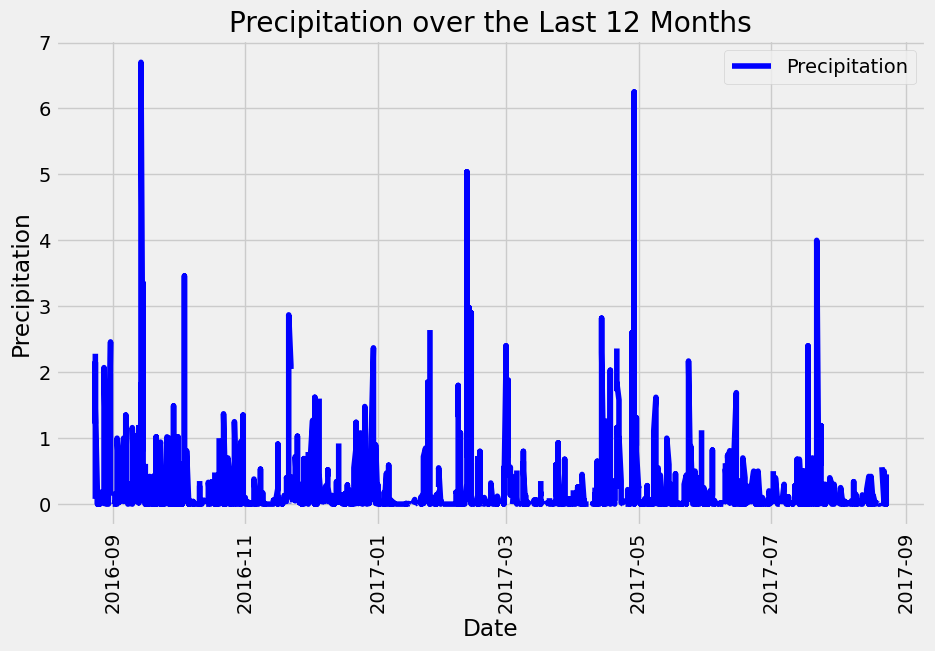

In [45]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
try:
    one_year_ago = most_recent_date - dt.timedelta(days=365)
    print(f"Date one year prior to the most recent date: {one_year_ago}")

# Perform a query to retrieve the data and precipitation scores
    results = session.query(Measurement.date, Measurement.prcp).\
        filter(Measurement.date >= one_year_ago).\
        order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
    df = pd.DataFrame(results, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')

# Print DataFrame for verification
    print(df.head())

# Use Pandas Plotting with Matplotlib to plot the data
    plt.figure(figsize=(10, 6))
    plt.plot(df['Date'], df['Precipitation'], label='Precipitation', color='blue')
    plt.xticks(rotation=90)
    plt.xlabel('Date')
    plt.ylabel('Precipitation')
    plt.title('Precipitation over the Last 12 Months')
    plt.legend()
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"Error during querying or plotting: {e}")

In [46]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = df['Precipitation'].describe()

print("Summary statistics for precipitation data:")
print(summary_stats)

Summary statistics for precipitation data:
count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [47]:
# Design a query to calculate the total number of stations in the dataset
try:
    total_stations = session.query(func.count(Station.id)).scalar()
    print(f"Total number of stations in the dataset: {total_stations}")

except Exception as e:
    print(f"Error during querying for the total number of stations: {e}")

Total number of stations in the dataset: 9


In [48]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
try:
    most_active_stations = session.query(
        Measurement.station,
        func.count(Measurement.station).label('count')
    ).group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
    
    # Print the results
    print("Most active stations and their counts (in descending order):")
    for station, count in most_active_stations:
        print(f"Station: {station}, Count: {count}")

except Exception as e:
    print(f"Error during querying for the most active stations: {e}")

Most active stations and their counts (in descending order):
Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [49]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
try:
    most_active_stations = session.query(
        Measurement.station,
        func.count(Measurement.station).label('count')
    ).group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
    
    # Get the most active station id (the first one in the list)
    most_active_station_id = most_active_stations[0][0]
    print(f"Most active station ID: {most_active_station_id}")

    # Query to get temperature statistics for the most active station
    temperature_stats = session.query(
        func.min(Measurement.tobs).label('min_temp'),
        func.max(Measurement.tobs).label('max_temp'),
        func.avg(Measurement.tobs).label('avg_temp')
    ).filter(Measurement.station == most_active_station_id).all()
    
    # Print the temperature statistics
    min_temp, max_temp, avg_temp = temperature_stats[0]
    print(f"Lowest temperature: {min_temp}")
    print(f"Highest temperature: {max_temp}")
    print(f"Average temperature: {avg_temp:.2f}")

except Exception as e:
    print(f"Error during querying for temperature statistics: {e}")

Most active station ID: USC00519281
Lowest temperature: 54.0
Highest temperature: 85.0
Average temperature: 71.66


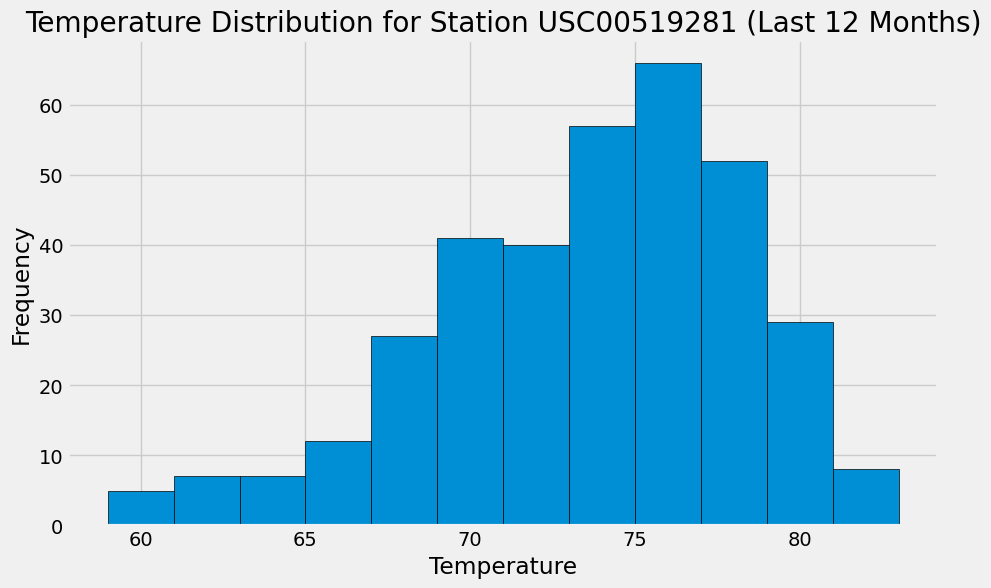

In [50]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
    
try:
    temperatures = session.query(Measurement.tobs).\
        filter(Measurement.station == most_active_station_id).\
        filter(Measurement.date >= one_year_ago).\
        order_by(Measurement.date).all()
    
    # Convert the query results to a DataFrame
    df = pd.DataFrame(temperatures, columns=['Temperature'])

    # Plot the histogram of temperature data
    plt.figure(figsize=(10, 6))
    plt.hist(df['Temperature'], bins=12, edgecolor='black')
    plt.xlabel('Temperature')
    plt.ylabel('Frequency')
    plt.title(f'Temperature Distribution for Station {most_active_station_id} (Last 12 Months)')
    plt.grid(True)

except Exception as e:
    print(f"Error during querying or plotting: {e}")

# Close Session

In [51]:
# Close Session
session.close()